# <center> <img src="../../img/ITESOLogo.png" alt="ITESO" width="480" height="130"> </center>
# <center> **Departamento de Electrónica, Sistemas e Informática** </center>
---
## <center> Computer Systems Engineering  </center>
---
### <center> Big Data Processing </center>
---
#### <center> **Autumn 2025** </center>

#### <center> **Final Project: Batch Processing** </center>
---

**Date**: October, 2025

**Student Name**: Ana Carolina Arellano Valdez

**Professor**: Pablo Camarillo Ramirez

# Introduction

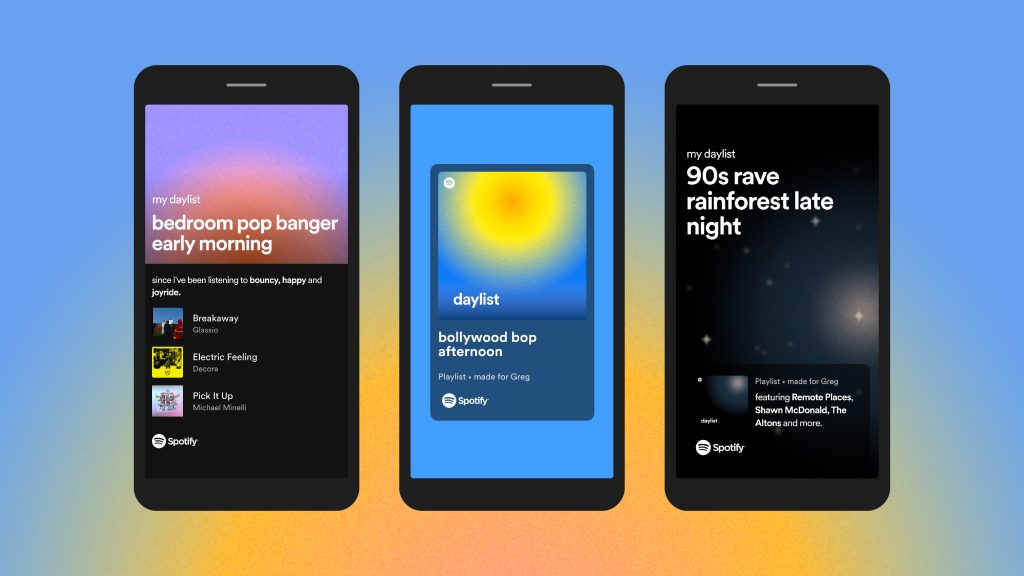 

In Spotify's recommendation system, keeping music suggestions accurate over time is a challenge. User tastes and trends change constantly, so I retrain the recommendation model regularly using historical data. This batch retraining process must handle large volumes of user interactions efficiently while ensuring that real-time recommendations remain uninterrupted.

The main challenge is finding the right balance between accuracy, performance, and scalability during model updates. In this project I demonstrate a batch processing solution using Apache Spark to process large-scale music streaming data for recommendation system training.

I structure user–music interaction signals (plays, skips, likes) to enable **smart, graph‑based recommendations**. A **graph** captures relationships between **Users**, **Tracks**, **Artists**, and **Genres**, letting me explore tastes and compute proximity (e.g., “users similar to me liked these tracks”, “tracks related by genre/artist/collective behavior”).

I process batched logs to aggregate listening preferences, then persist this knowledge into **Neo4j**, where I can query paths, neighbors, and weighted relationships for recommendations.

# Dataset

**Data model:** Graph.  
**Entities & relationships (simplified):**
- **User** node: `user_id`
- **Track** node: `track_id`, `title/album`, `duration_ms`
- **Artist** node: `name`
- **Genre** node: `name`
- **Relationships:**  
  - `(User)-[:PLAYED {count, last_ts}]->(Track)`  
  - `(User)-[:LIKED {count, last_ts}]->(Track)`  
  - `(Track)-[:BY]->(Artist)`  
  - `(Track)-[:IN_GENRE]->(Genre)`

**How the dataset is obtained:** We generate synthetic data with a Python script (`fake_data.py`) using the **Faker** library.
The script produces two CSVs: `tracks.csv` and `user_events.csv` in `data/carolinarellano/spotify_logs/`.


### Synthetic Data Generation

In [1]:
# Import the custom data generator
from carolinarellano.fake_data import FakeDataGenerator

# Initialize the generator
generator = FakeDataGenerator()

tracks_df, events_df = generator.generate_and_save_all(
    n_tracks=250,      
    n_users=50,
    n_events=1000
)

Generating fake data...
Saved tracks.csv with 250 rows to /opt/spark/work-dir/data/carolinarellano/spotify_logs/tracks.csv
Saved user_events.csv with 1000 rows to /opt/spark/work-dir/data/carolinarellano/spotify_logs/user_events.csv
Data generation complete!


## Data Verification

In [5]:
!pwd
!ls -la /opt/spark/work-dir/data/carolinarellano/spotify_logs

/opt/spark/work-dir
total 92
drwxr-xr-x 1 root root  4096 Oct 29 18:30 .
drwxr-xr-x 1 root root  4096 Oct 29 18:30 ..
-rw-r--r-- 1 root root 14136 Oct 30 13:03 tracks.csv
-rw-r--r-- 1 root root 75317 Oct 30 13:03 user_events.csv


# Spark Processing Pipeline

## Data Transformations and Actions

In [6]:
import findspark
findspark.init()

from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Examples on storage solutions with Neo4j") \
    .master("spark://spark-master:7077") \
    .config("spark.jars.packages", "org.neo4j:neo4j-connector-apache-spark_2.13:5.3.10_for_spark_3") \
    .config("spark.ui.port", "4040") \
    .getOrCreate()

sc = spark.sparkContext
sc.setLogLevel("ERROR")
spark.conf.set("spark.sql.shuffle.partitions", "5")

:: loading settings :: url = jar:file:/opt/spark/jars/ivy-2.5.3.jar!/org/apache/ivy/core/settings/ivysettings.xml
Ivy Default Cache set to: /root/.ivy2.5.2/cache
The jars for the packages stored in: /root/.ivy2.5.2/jars
org.neo4j#neo4j-connector-apache-spark_2.13 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-167aaad0-1baa-4e0a-8087-5ff5941b5c7c;1.0
	confs: [default]
	found org.neo4j#neo4j-connector-apache-spark_2.13;5.3.10_for_spark_3 in central
	found org.neo4j#neo4j-connector-apache-spark_2.13_common;5.3.10_for_spark_3 in central
	found org.neo4j#caniuse-core;1.3.0 in central
	found org.neo4j#caniuse-api;1.3.0 in central
	found org.jetbrains.kotlin#kotlin-stdlib;2.1.20 in central
	found org.jetbrains#annotations;13.0 in central
	found org.neo4j#caniuse-neo4j-detection;1.3.0 in central
	found org.neo4j.driver#neo4j-java-driver-slim;4.4.21 in central
	found org.reactivestreams#reactive-streams;1.0.4 in central
	found io.netty#netty-handler;4.1.

### Load Data into Spark DataFrames

In [7]:
DATA_DIR = "/opt/spark/work-dir/data/carolinarellano/spotify_logs"

from carolinarellano.spark_utils import SparkUtils

schema_tracks = SparkUtils.generate_schema([("track_id", "string"),
                                  ("artist", "string"),
                                  ("album", "string"),
                                  ("duration_ms", "int"),
                                  ("genre", "string")])



schema_events = SparkUtils.generate_schema([("user_id", "string"),
                                  ("track_id", "string"),
                                  ("event_type", "string"),
                                  ("event_ts", "timestamp"),
                                  ("session_id", "string"),
                                  ("device", "string")])

df_tracks = spark.read.schema(schema_tracks).option("header", True).csv(f"{DATA_DIR}/tracks.csv")
df_events = spark.read.schema(schema_events).option("header", True).csv(f"{DATA_DIR}/user_events.csv")


In [8]:
from pyspark.sql.functions import col, to_timestamp

events_clean = (
    df_events
    .withColumn("event_ts", to_timestamp(col("event_ts").cast("string")))
    .filter(col("event_type").isin("play", "skip", "like", "pause", "seek"))
)

spotify_tracks_events = (
    events_clean.alias("e")
    .join(df_tracks.alias("t"), col("e.track_id") == col("t.track_id"), "left")
    .select("e.*", "t.artist", "t.album", "t.genre", "t.duration_ms")
)

# Tracks
tracks_nodes = spotify_tracks_events.select("track_id", "artist", "album", "genre", "duration_ms").distinct()
users_nodes = spotify_tracks_events.select("user_id", "device").distinct()
artists_nodes = tracks_nodes.select("artist").distinct().withColumnRenamed("artist", "name")
genres_nodes = tracks_nodes.select("genre").distinct().withColumnRenamed("genre", "name")

# Edges
# User -> Track relationships
user_track_edges = spotify_tracks_events.select(
    col("user_id").alias("source_user"),
    col("track_id").alias("target_track"),
    col("event_type"),
    col("event_ts"),
    col("session_id"),
    col("device")
).distinct()

# Track -> Artist relationships
track_artist_edges = tracks_nodes.select(
    col("track_id").alias("source_track"),
    col("artist").alias("target_artist")
).distinct()

# Track -> Genre relationships 
track_genre_edges = tracks_nodes.select(
    col("track_id").alias("source_track"),
    col("genre").alias("target_genre")
).distinct()


# Persistence Data

In [12]:
neo4j_url = "bolt://neo4j-iteso:7687"
neo4j_user = "neo4j"
neo4j_passwd = "neo4j@1234"

In [ ]:
# User-Track relationships by event type
from pyspark.sql.functions import trim, lower

tracks_nodes.write \
    .format("org.neo4j.spark.DataSource") \
    .mode("Overwrite") \
    .option("url", neo4j_url) \
    .option("authentication.basic.username", neo4j_user) \
    .option("authentication.basic.password", neo4j_passwd) \
    .option("labels", ":Track") \
    .option("node.keys", "track_id") \
    .save()

print(f"{tracks_nodes.count()} track nodes written to Neo4j.")

users_nodes.write \
    .format("org.neo4j.spark.DataSource") \
    .mode("Overwrite") \
    .option("url", neo4j_url) \
    .option("authentication.basic.username", neo4j_user) \
    .option("authentication.basic.password", neo4j_passwd) \
    .option("labels", ":User") \
    .option("node.keys", "user_id") \
    .save()

print(f"{users_nodes.count()} user nodes written to Neo4j.")

artists_nodes.write \
    .format("org.neo4j.spark.DataSource") \
    .mode("Overwrite") \
    .option("url", neo4j_url) \
    .option("authentication.basic.username", neo4j_user) \
    .option("authentication.basic.password", neo4j_passwd) \
    .option("labels", ":Artist") \
    .option("node.keys", "name") \
    .save()

print(f"{artists_nodes.count()} artist nodes written to Neo4j.")

genres_nodes.write \
    .format("org.neo4j.spark.DataSource") \
    .mode("Overwrite") \
    .option("url", neo4j_url) \
    .option("authentication.basic.username", neo4j_user) \
    .option("authentication.basic.password", neo4j_passwd) \
    .option("labels", ":Genre") \
    .option("node.keys", "name") \
    .save()

print(f"{genres_nodes.count()} genre nodes written to Neo4j.")


247 track nodes written to Neo4j.
200 user nodes written to Neo4j.


247 artist nodes written to Neo4j.
9 genre nodes written to Neo4j.


In [14]:
# Event types
plays_clean = (
    user_track_edges
    .filter(col("event_type") == "play")
    .select(
        trim(lower(col("source_user"))).alias("source_user"),
        trim(lower(col("target_track"))).alias("target_track"),
        col("event_type")
    )
    .dropna(subset=["source_user", "target_track"])
    .distinct()
)

likes_clean = (
    user_track_edges
    .filter(col("event_type") == "like")
    .select(
        trim(lower(col("source_user"))).alias("source_user"),
        trim(lower(col("target_track"))).alias("target_track"),
        col("event_type")
    )
    .dropna(subset=["source_user", "target_track"])
    .distinct()
)

skips_clean = (
    user_track_edges
    .filter(col("event_type") == "skip")
    .select(
        trim(lower(col("source_user"))).alias("source_user"),
        trim(lower(col("target_track"))).alias("target_track"),
        col("event_type")
    )
    .dropna(subset=["source_user", "target_track"])
    .distinct()
)

pause_clean = (
    user_track_edges
    .filter(col("event_type") == "pause")
    .select(
        trim(lower(col("source_user"))).alias("source_user"),
        trim(lower(col("target_track"))).alias("target_track"),
        col("event_type")
    )
    .dropna(subset=["source_user", "target_track"])
    .distinct()
)

seek_clean = (
    user_track_edges
    .filter(col("event_type") == "seek")
    .select(
        trim(lower(col("source_user"))).alias("source_user"),
        trim(lower(col("target_track"))).alias("target_track"),
        col("event_type")
    )
    .dropna(subset=["source_user", "target_track"])
    .distinct()
)


In [15]:

plays_clean.write \
    .format("org.neo4j.spark.DataSource") \
    .mode("Append") \
    .option("url", neo4j_url) \
    .option("authentication.basic.username", neo4j_user) \
    .option("authentication.basic.password", neo4j_passwd) \
    .option("relationship", "PLAYED") \
    .option("relationship.save.strategy", "keys") \
    .option("relationship.source.labels", ":User") \
    .option("relationship.source.save.mode", "match") \
    .option("relationship.source.node.keys", "source_user:user_id") \
    .option("relationship.target.labels", ":Track") \
    .option("relationship.target.save.mode", "match") \
    .option("relationship.target.node.keys", "target_track:track_id") \
    .save()

print(f"{plays_clean.count()} PLAYED relationships written to Neo4j.")

likes_clean.write \
    .format("org.neo4j.spark.DataSource") \
    .mode("Overwrite") \
    .option("url", neo4j_url) \
    .option("authentication.basic.username", neo4j_user) \
    .option("authentication.basic.password", neo4j_passwd) \
    .option("relationship", "LIKED") \
    .option("relationship.save.strategy", "keys") \
    .option("relationship.source.labels", ":User") \
    .option("relationship.source.save.mode", "Match") \
    .option("relationship.source.node.keys", "source_user:user_id") \
    .option("relationship.target.labels", ":Track") \
    .option("relationship.target.save.mode", "Match") \
    .option("relationship.target.node.keys", "target_track:track_id") \
    .save()

print(f"{likes_clean.count()} LIKED relationships written to Neo4j.")

skips_clean.write \
    .format("org.neo4j.spark.DataSource") \
    .mode("Overwrite") \
    .option("url", neo4j_url) \
    .option("authentication.basic.username", neo4j_user) \
    .option("authentication.basic.password", neo4j_passwd) \
    .option("relationship", "SKIPPED") \
    .option("relationship.save.strategy", "keys") \
    .option("relationship.source.labels", ":User") \
    .option("relationship.source.save.mode", "Match") \
    .option("relationship.source.node.keys", "source_user:user_id") \
    .option("relationship.target.labels", ":Track") \
    .option("relationship.target.save.mode", "Match") \
    .option("relationship.target.node.keys", "target_track:track_id") \
    .save()

print(f"{skips_clean.count()} SKIPPED relationships written to Neo4j.")

pause_clean.write \
    .format("org.neo4j.spark.DataSource") \
    .mode("Overwrite") \
    .option("url", neo4j_url) \
    .option("authentication.basic.username", neo4j_user) \
    .option("authentication.basic.password", neo4j_passwd) \
    .option("relationship", "PAUSED") \
    .option("relationship.save.strategy", "keys") \
    .option("relationship.source.labels", ":User") \
    .option("relationship.source.save.mode", "Match") \
    .option("relationship.source.node.keys", "source_user:user_id") \
    .option("relationship.target.labels", ":Track") \
    .option("relationship.target.save.mode", "Match") \
    .option("relationship.target.node.keys", "target_track:track_id") \
    .save()

print(f"{pause_clean.count()} PAUSED relationships written to Neo4j.")
    
seek_clean.write \
    .format("org.neo4j.spark.DataSource") \
    .mode("Overwrite") \
    .option("url", neo4j_url) \
    .option("authentication.basic.username", neo4j_user) \
    .option("authentication.basic.password", neo4j_passwd) \
    .option("relationship", "SEEKED") \
    .option("relationship.save.strategy", "keys") \
    .option("relationship.source.labels", ":User") \
    .option("relationship.source.save.mode", "Match") \
    .option("relationship.source.node.keys", "source_user:user_id") \
    .option("relationship.target.labels", ":Track") \
    .option("relationship.target.save.mode", "Match") \
    .option("relationship.target.node.keys", "target_track:track_id") \
    .save()

print(f"{seek_clean.count()} SEEKED relationships written to Neo4j.")

607 PLAYED relationships written to Neo4j.
92 LIKED relationships written to Neo4j.
178 SKIPPED relationships written to Neo4j.
52 PAUSED relationships written to Neo4j.
55 SEEKED relationships written to Neo4j.


In [16]:
artists_nodes.write \
    .format("org.neo4j.spark.DataSource") \
    .mode("Overwrite") \
    .option("url", neo4j_url) \
    .option("authentication.basic.username", neo4j_user) \
    .option("authentication.basic.password", neo4j_passwd) \
    .option("labels", ":Artist") \
    .option("node.keys", "name") \
    .save()

genres_nodes.write \
    .format("org.neo4j.spark.DataSource") \
    .mode("Overwrite") \
    .option("url", neo4j_url) \
    .option("authentication.basic.username", neo4j_user) \
    .option("authentication.basic.password", neo4j_passwd) \
    .option("labels", ":Genre") \
    .option("node.keys", "name") \
    .save()

track_artist_edges.write \
    .format("org.neo4j.spark.DataSource") \
    .mode("Append") \
    .option("url", neo4j_url) \
    .option("authentication.basic.username", neo4j_user) \
    .option("authentication.basic.password", neo4j_passwd) \
    .option("relationship", "BY") \
    .option("relationship.save.strategy", "keys") \
    .option("relationship.source.labels", ":Track") \
    .option("relationship.source.save.mode", "Match") \
    .option("relationship.source.node.keys", "source_track:track_id") \
    .option("relationship.target.labels", ":Artist") \
    .option("relationship.target.save.mode", "Match") \
    .option("relationship.target.node.keys", "target_artist:name") \
    .save()

print(f"{track_artist_edges.count()} Track -> Artist relationships loaded")

track_genre_edges.write \
    .format("org.neo4j.spark.DataSource") \
    .mode("Append") \
    .option("url", neo4j_url) \
    .option("authentication.basic.username", neo4j_user) \
    .option("authentication.basic.password", neo4j_passwd) \
    .option("relationship", "IN_GENRE") \
    .option("relationship.save.strategy", "keys") \
    .option("relationship.source.labels", ":Track") \
    .option("relationship.source.save.mode", "Match") \
    .option("relationship.source.node.keys", "source_track:track_id") \
    .option("relationship.target.labels", ":Genre") \
    .option("relationship.target.save.mode", "Match") \
    .option("relationship.target.node.keys", "target_genre:name") \
    .save()

print(f"{track_genre_edges.count()} Track -> Genre relationships loaded")

247 Track -> Artist relationships loaded
247 Track -> Genre relationships loaded


# Neo4j Database

### MATCH (t:Track)-[r:BY]->(a:Artist) RETURN t, r, a
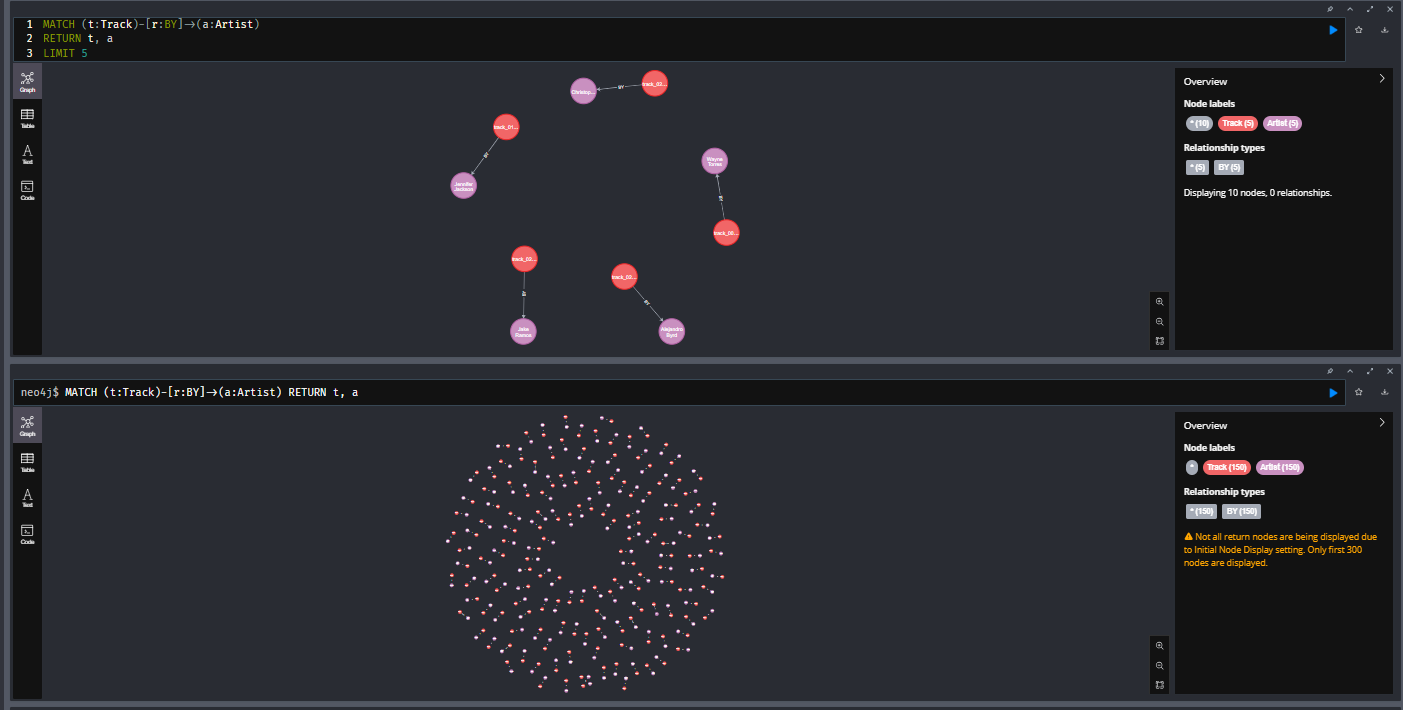


### MATCH (t:Track)-[r:IN_GENRE]->(g:Genre) RETURN t, r, g
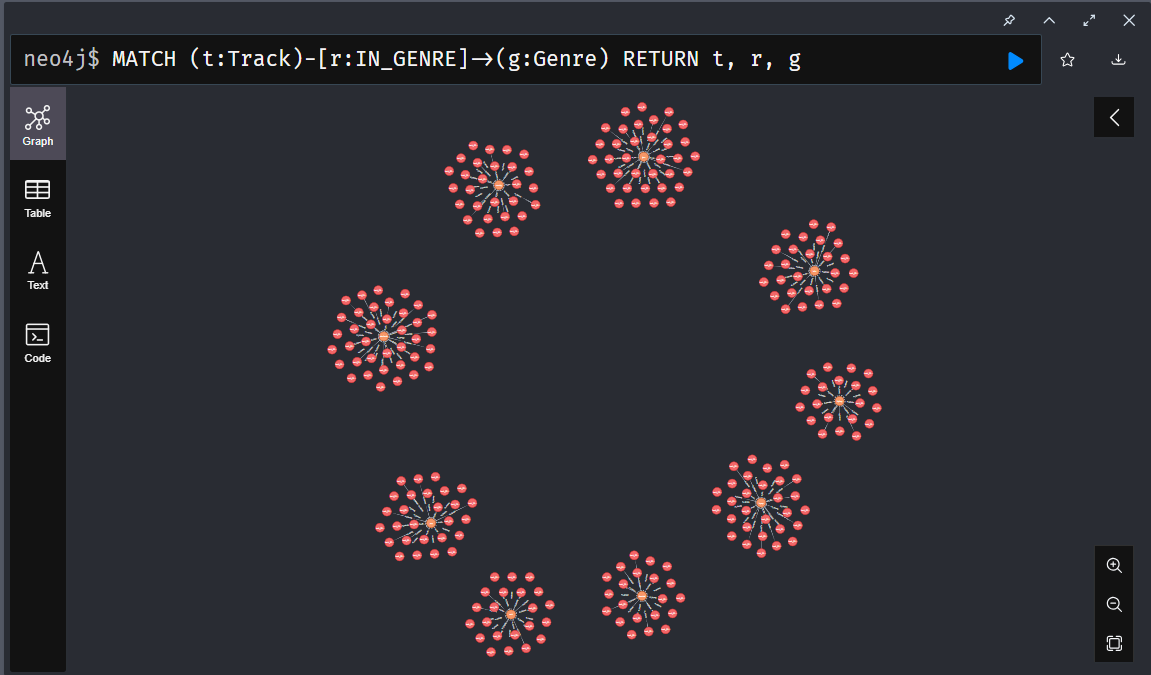

### MATCH (u:User)-[r:PLAYED]->(t:Track) RETURN u, r, t
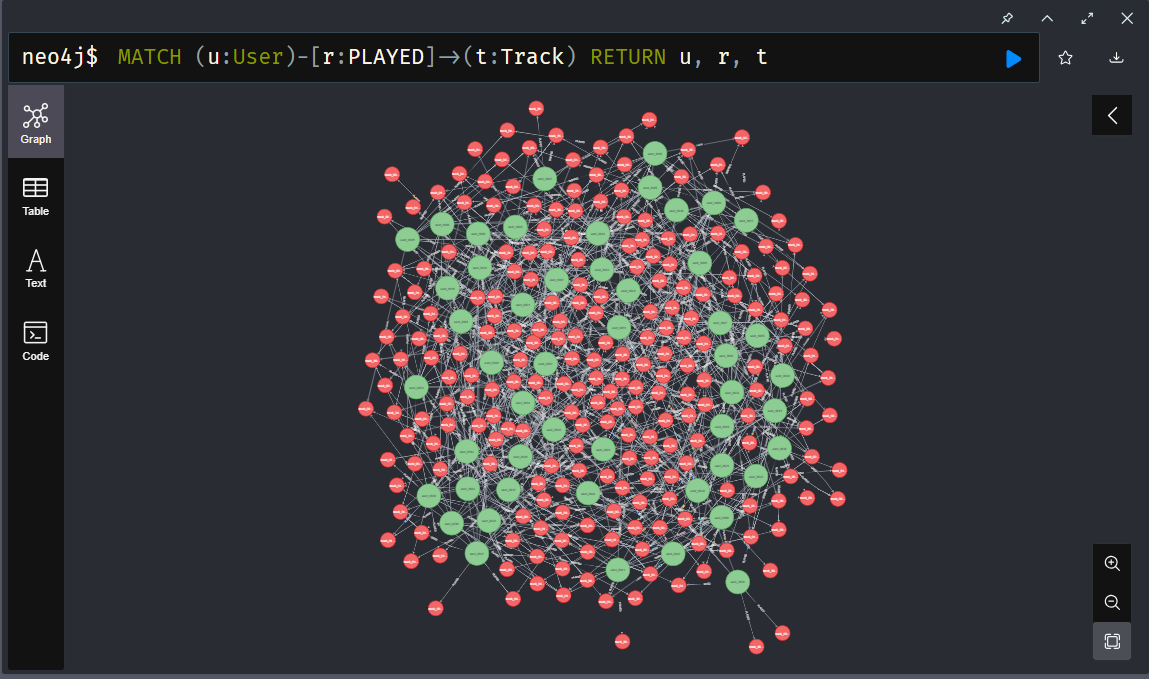
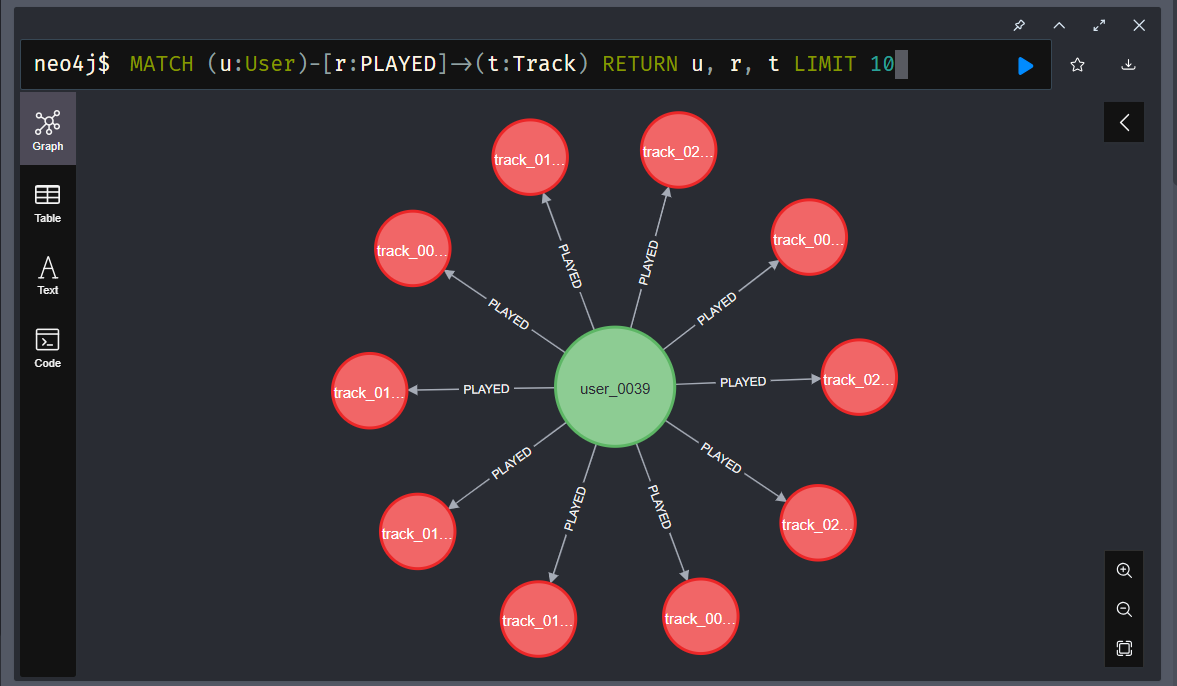


### Sample Queries in Neo4j Browser

1) A user's top liked tracks
```cypher
MATCH (u:User {user_id:"user_0042" })-[l:LIKED]->(t:Track)
RETURN u.user_id AS user, t.track_id AS track
```
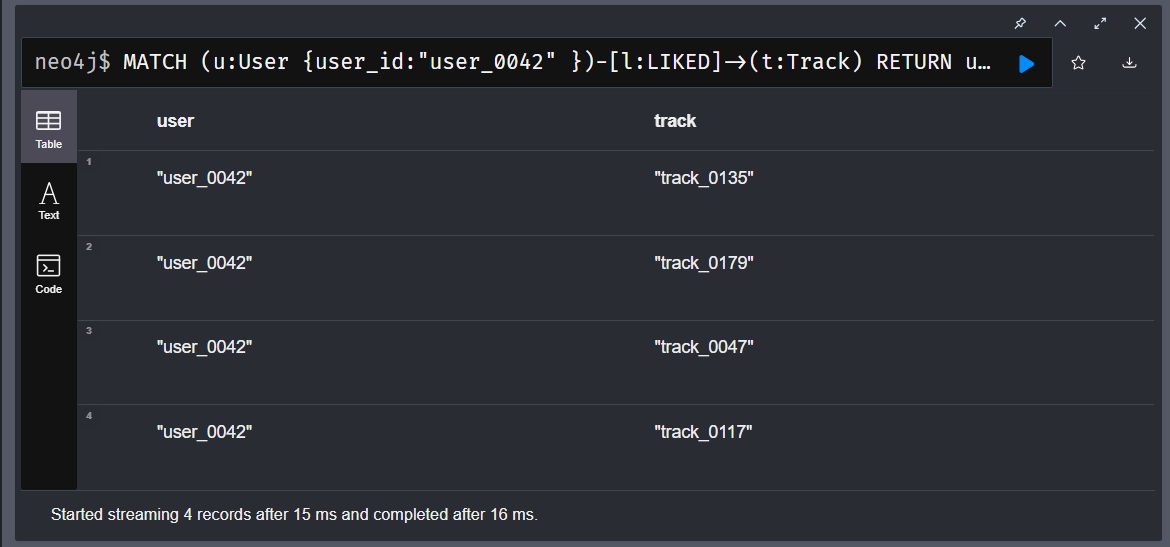

2) Tracks by a specific artist
```cypher
MATCH (a:Artist {name: "Artist_10"})<-[:BY]-(t:Track)
RETURN t.track_id AS track, a.name AS artist
```
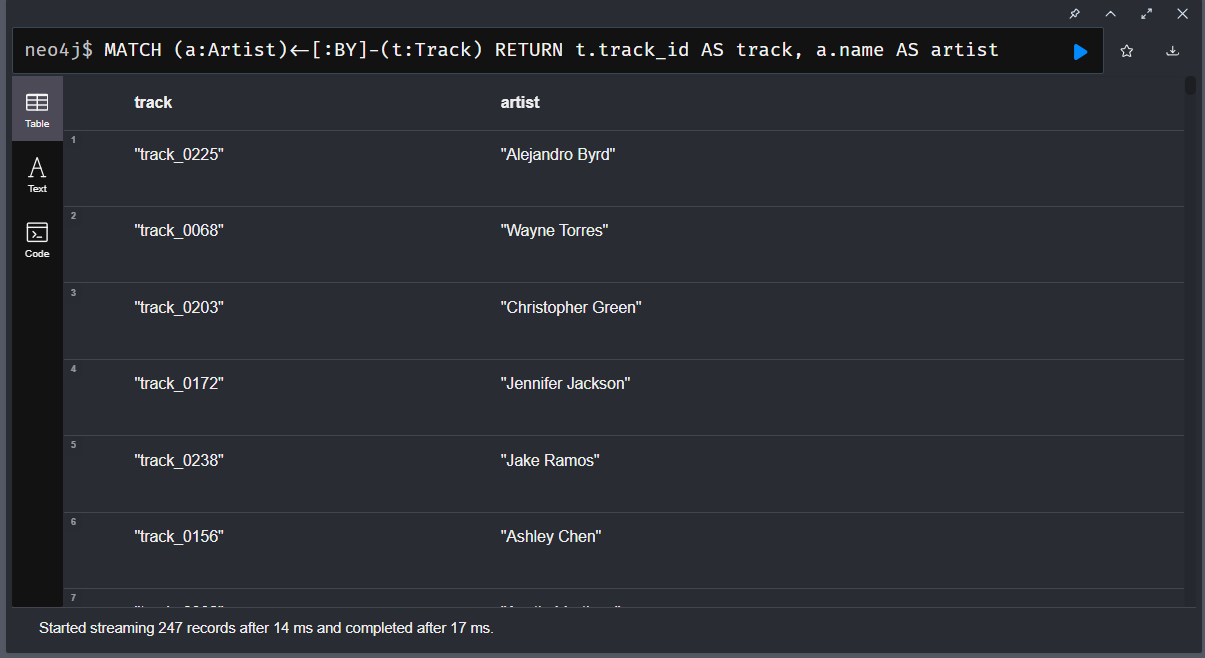

3) Tracks paused
```cypher
MATCH (u:User)-[r:PAUSED]->(t:Track)
RETURN u.user_id AS user, t.track_id AS track_paused
LIMIT 10;

```
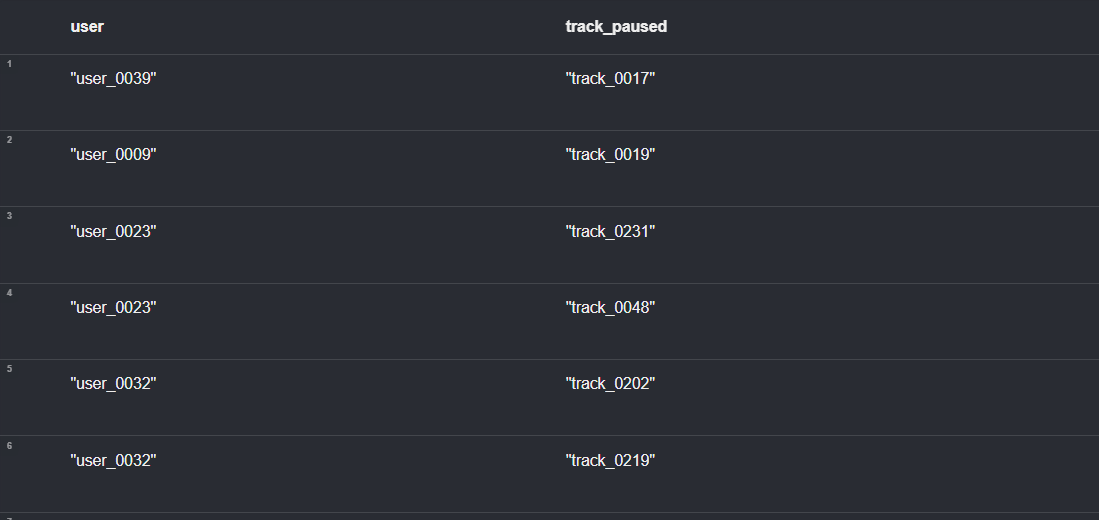

# DAG (Directed Acyclic Graph)

## Jobs Overview:
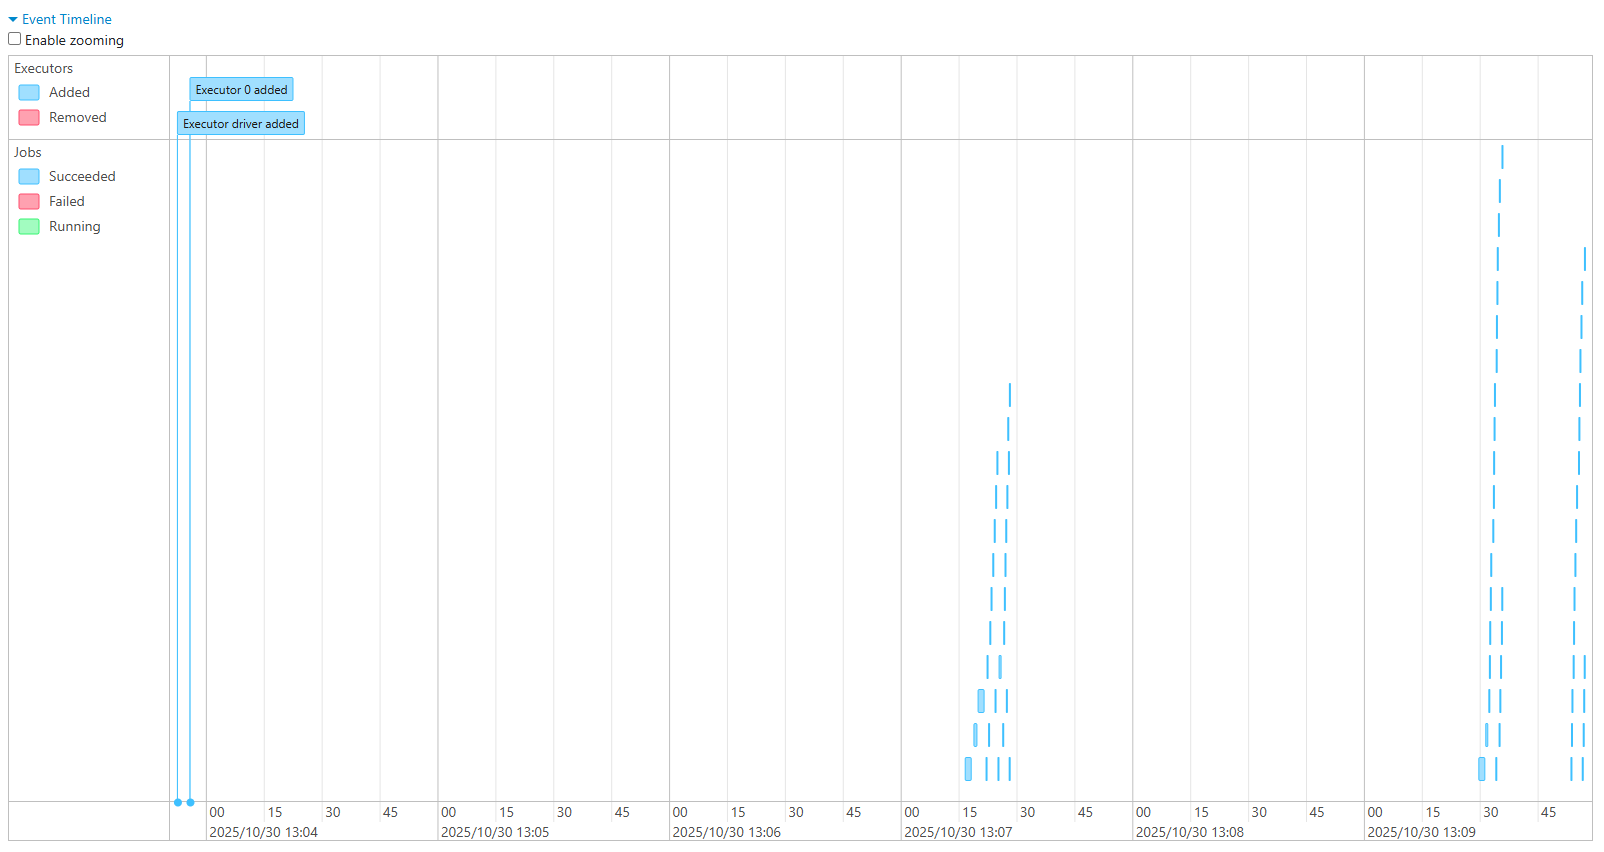


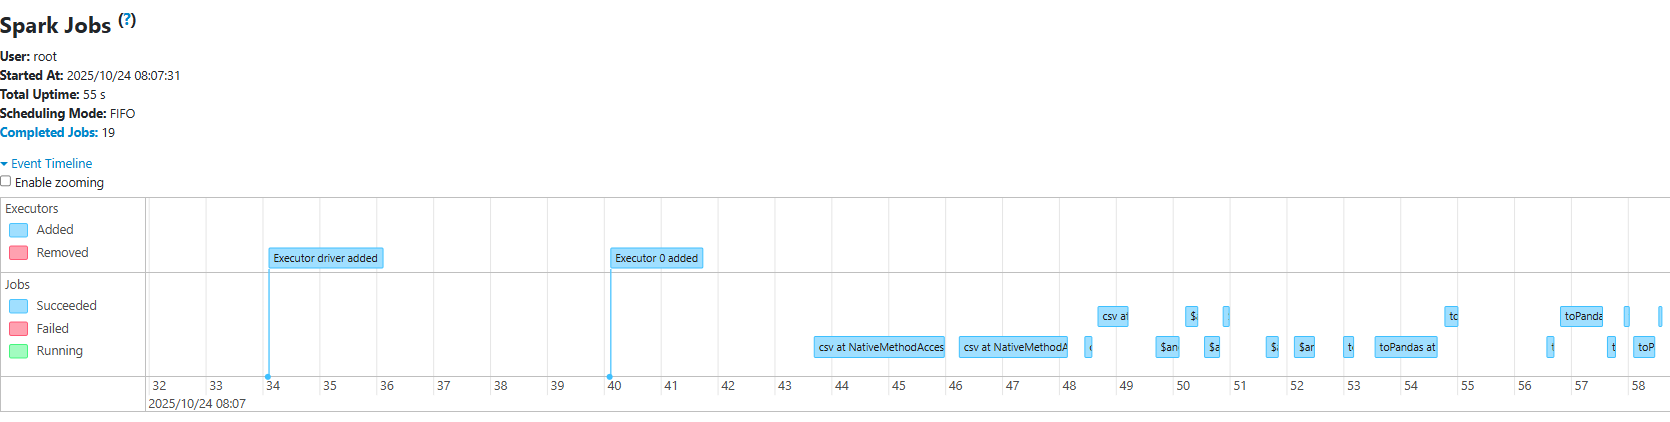

## Stage Visualization
### Job Stages
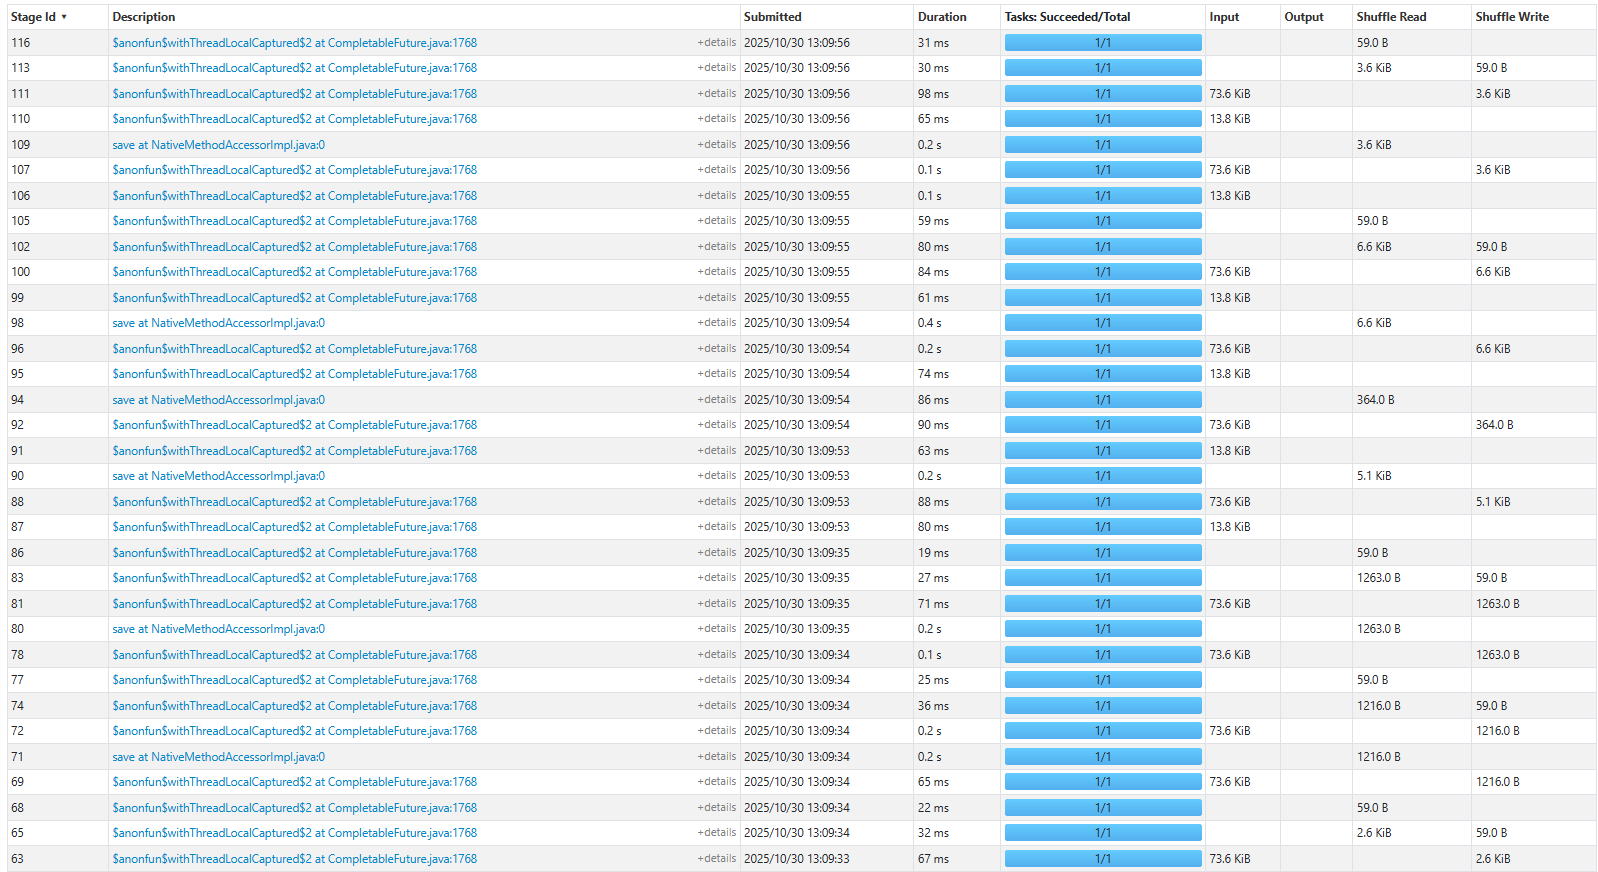

### Job Details
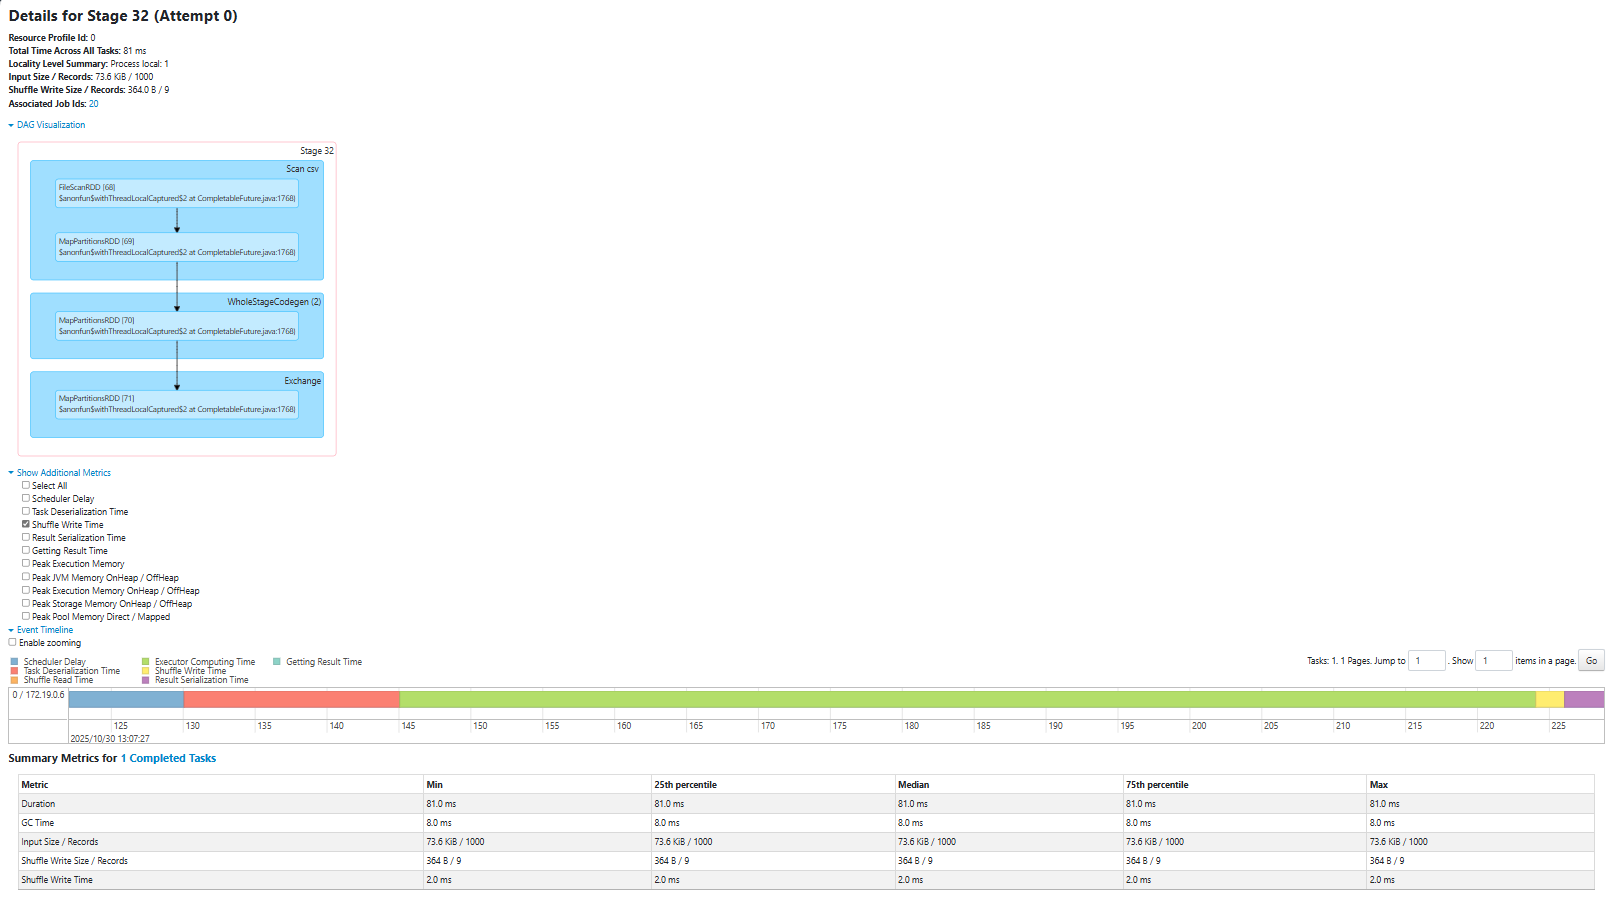

In [9]:
sc.stop()